In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns
import os
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from scipy.stats import zscore
import pingouin as pg
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


## import data

In [19]:
dir = '/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/data_initial_submission'
syncDT = pd.read_excel('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/sync.xlsx', header=None)
exps = [i.split('_sync.png')[0] for i in syncDT.loc[~syncDT[2].isnull(), 2].to_list()]
trial_type = 'uncued'  # 'Randomized', '3+12Hz', 'Opto2zones', 'uncued', 'lidocaine'
expselect = [i for i in exps if any(j in i for j in ['Randomized', '3+12Hz', 'check'])]
expselect

['20191203_#212_LFPcheck',
 '20191203_#214_LFPcheck',
 '20191203_#220_LFPcheck',
 '20191204_#212_Optocheck',
 '20191204_#214_Optocheck',
 '20191204_#221_Optocheck',
 '20191204_#224_Optocheck',
 '20191205_#212_3+12Hz',
 '20191205_#214_3+12Hz',
 '20191205_#218_3+12Hz',
 '20191205_#219_3+12Hz',
 '20191205_#220_3+12Hz',
 '20191205_#221_3+12Hz',
 '20191205_#222_3+12Hz',
 '20191205_#223_3+12Hz',
 '20191205_#224_3+12Hz',
 '20191206_#220_Randomized',
 '20191208_#212_Randomized',
 '20191208_#214_Randomized',
 '20191208_#220_Randomized',
 '20191208_#221_Randomized',
 '20191210_#212_Randomized',
 '20191210_#214_Randomized',
 '20191210_#216_Randomized',
 '20191210_#220_Randomized',
 '20191210_#221_Randomized',
 '20191217_#212_Randomized',
 '20191217_#222_Randomized',
 '20191217_#223_Randomized',
 '20191217_#224_Randomized']

In [3]:
data = []

for exp in tqdm(expselect):
    data_exp = pd.read_hdf(os.path.join(dir, exp+'.h5'), 'behaviour')
    analogue_columns = ['sweep_index', 'position_raw', 'licking', 'pump', 'optotrigger',
       'camtrigger_raw', 'sweep', 'camtrigger', 'optobout', 'opto_freq',
       'position', 'velocity']
    if exp == '20191210_#214_Randomized':  # fix broken sync
        data_exp[analogue_columns] = data_exp[analogue_columns].shift(1350)
        data_exp = data_exp.iloc[1350:].reset_index(drop=True)
    if exp == '20200217_#212_lidocaine':  # fix broken sync
        data_exp.loc[data_exp.iloc[145_000:].index, analogue_columns] = data_exp[analogue_columns].iloc[145_000:].shift(340)
        data_exp = data_exp.dropna(subset=['sweep_index', 'optobout']).reset_index(drop=True)
    if exp == '20200217_#221_lidocaine':  # fix broken sync
        data_exp.loc[data_exp.iloc[50_000:].index, analogue_columns] = data_exp[analogue_columns].iloc[50_000:].shift(350).dropna(subset=['sweep_index', 'optobout'])
        data_exp.loc[data_exp.iloc[106_000:].index, analogue_columns] = data_exp[analogue_columns].iloc[106_000:].shift(-2325).dropna(subset=['sweep_index', 'optobout'])
        data_exp = data_exp.dropna(subset=['sweep_index', 'optobout']).reset_index(drop=True)
    data_exp['Date'] = exp.split('_')[0]
    data_exp['Mouse'] = exp.split('#')[1][:3]
    data_exp['Group'] = 'ChR' if exp.split('#')[1][:3] in ['212','219', '220','221','222','224'] else 'EYFP'
    data_exp['Trial'] = ''.join(exp.split('_')[2:])
    data_exp['Experiment'] = exp
    if trial_type == 'lidocaine':
        data_exp['lidocaine'] = np.nan#'inj'
        # if exp.split('#')[1][:3] == '212':
        data_exp.loc[data_exp.sweep<13, 'lidocaine'] = 'baseline'
        data_exp.loc[data_exp.sweep>17, 'lidocaine'] = 'lidocaine'
    data_exp['Time'] = np.linspace(start=0, stop=len(data_exp)/75, num=len(data_exp))
    data_exp['Time_ds'] = (data_exp.Time*10).astype(int)
    if 'optobout' not in data_exp.columns:
        data_exp['optobout'] = data_exp.optotrigger.astype(int).rolling(25, center=True).max().fillna(0).astype(bool)
    if 'opto_freq' not in data_exp.columns:
        data_exp['opto_freq'] = round((((data_exp.optotrigger.diff()==1).astype(int).rolling(75).mean())/.012).fillna(0)/3)*3
        data_exp.loc[data_exp.opto_freq==0, 'opto_freq'] = np.nan
        data_exp['opto_freq'] = data_exp['opto_freq'].rolling(75, center=True).max()
    data_exp['Opto_extended'] = (data_exp.optobout.rolling(300, center=True).mean()>0).astype(int)

    # resting periods
    rest_idx_raw = data_exp.index[data_exp.velocity<2]
    rest_epochs = (pd.Series(rest_idx_raw).diff()!=1).astype(int).cumsum()
    data_exp.loc[rest_idx_raw, 'rest_epochs'] = rest_epochs.values
    rest_epoch_counts = rest_epochs.value_counts()
    long_rest_epochs = rest_epoch_counts.index[rest_epoch_counts > 150].to_list()
    data_exp['long_rest'] = 0
    data_exp.loc[data_exp.rest_epochs.isin(long_rest_epochs), 'long_rest'] = 1
    
    # locomotion periods
    data_exp['locomotion_epochs'] = np.nan
    loco_idx_raw = data_exp.index[data_exp.velocity>2]
    loco_epochs = (pd.Series(loco_idx_raw).diff()!=1).astype(int).cumsum()
    data_exp.loc[loco_idx_raw, 'locomotion_epochs'] = loco_epochs.values
    loco_epoch_counts = loco_epochs.value_counts()
    long_loco_epochs = loco_epoch_counts.index[loco_epoch_counts > 150].to_list()
    loco_epochs_after_rest = list((data_exp['locomotion_epochs'].shift(-75)*data_exp['long_rest']).unique()[:-1].astype(int))
    data_exp['long_locomotion'] = 0
    data_exp.loc[data_exp.locomotion_epochs.isin(list(set(long_loco_epochs) & set(loco_epochs_after_rest))), 'long_locomotion'] = 1
    
    # indeces
    idx = {}
    idx['onset_opto'] = data_exp.index[data_exp.optobout.astype(int).diff()==1].to_list()
    idx['onset_opto_loco'] = [i for i in idx['onset_opto'] if data_exp.loc[data_exp.iloc[i:i+1500].index, 'velocity'].max()>2]
    idx['onset_longloco'] = data_exp.index[data_exp.long_locomotion.astype(int).diff()==1].to_list()
    idx['onset_longloco_noopto'] = [i for i in idx['onset_longloco'] if i not in data_exp.index[data_exp['Opto_extended']==1].to_list()]
    idx['opto_noloco'] = [i for i in idx['onset_opto'] if data_exp.velocity.iloc[i:i+750].mean()<2]
    for j in ['OFmag_Whiskerpad', 'OFmag_Nose']:
        idx['onset_'+j] = data_exp.index[(zscore(data_exp[j].rolling(5, center=True).mean().diff().fillna(0))>1)].to_list()
        idx['onset_'+j] = [i for i in idx['onset_'+j] if i>37]
        idx['onset_'+j] = pd.Series(idx['onset_'+j]).iloc[(pd.Series(idx['onset_'+j]).diff()>37).to_list()].to_list()

    # on/offset times into dataframe
    def onset_timing(behaviour_exp, onset_name, ffill_limit):
        behaviour_exp['onset_time'] = np.nan
        behaviour_exp.loc[(behaviour_exp[onset_name]==1), 'onset_time'] = behaviour_exp.loc[(behaviour_exp[onset_name]==1), 'Time_ds']
        behaviour_exp.onset_time = behaviour_exp.onset_time.fillna(method='ffill', limit=ffill_limit).fillna(method='bfill', limit=int(ffill_limit/6))
        behaviour_exp['onset_time'] = behaviour_exp.Time_ds - behaviour_exp.onset_time
        return behaviour_exp['onset_time']
    
    for key in idx.keys():
        data_exp[key] = 0
        data_exp.loc[idx[key], key] = 1
        ffill_limit = int(30/data_exp.Time.diff().mean())
        data_exp[key+'_time'] = onset_timing(data_exp, key, ffill_limit)
        data_exp[key+'_epoch'] = data_exp[key].cumsum().shift(int(ffill_limit/6))
    
    # for/backward fill opto_freq:
    data_exp['opto_freq_sharp'] = data_exp['opto_freq'].copy()
    data_exp.loc[data_exp.opto_freq_sharp.isnull(), 'opto_freq_sharp'] = 0
    ffill_limit = int(30/data_exp.Time.diff().mean())
    data_exp['opto_freq'] = data_exp['opto_freq'].fillna(method='ffill', limit=ffill_limit).fillna(method='bfill', limit=int(ffill_limit/6))
    
    data.append(data_exp)
data = pd.concat(data)

data['Saccades'] = data['Saccades'].fillna(0).astype(bool)
data['EyeBlinks'] = data['EyeBlinks'].fillna(0).astype(bool)
data['optobout'] = data['optobout'].fillna(0).astype(bool)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
100%|██████████| 30/30 [00:03<00:00,  7.85it/s]


## Load data

In [24]:
# LOAD DATA
trial_type = 'uncued'
data = pd.read_feather('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/uncued.feather')
data

,sweep_index,position_raw,licking,pump,optotrigger,camtrigger_raw,sweep,camtrigger,optobout,opto_freq,...,onset_OFmag_Whiskerpad_epoch,onset_OFmag_Nose,onset_OFmag_Nose_time,onset_OFmag_Nose_epoch,opto_freq_sharp,stride_epoch,PupilDiam,PupilX,PupilY,Saccades
0,71.0,-2.425312,0.000625,-0.000625,0.0,0.0,1.0,0.0,False,NaN,...,NaN,0,-13.0,NaN,0.0,NaN,NaN,NaN,NaN,False
1,209.0,-2.424062,0.000625,-0.000625,0.0,0.0,1.0,0.0,False,NaN,...,NaN,0,-13.0,NaN,0.0,NaN,NaN,NaN,NaN,False
2,342.0,-2.423750,0.000625,-0.000937,0.0,0.0,1.0,0.0,False,NaN,...,NaN,0,-13.0,NaN,0.0,NaN,NaN,NaN,NaN,False
3,475.0,-2.422188,0.000625,-0.000625,0.0,0.0,1.0,0.0,False,NaN,...,NaN,0,-13.0,NaN,0.0,NaN,NaN,NaN,NaN,False
4,608.0,-2.420000,0.000625,-0.000625,0.0,0.0,1.0,0.0,False,NaN,...,NaN,0,-13.0,NaN,0.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631145,597911.0,-2.410312,0.000625,0.002500,0.0,0.0,23.0,0.0,False,3.0,...,78.0,0,NaN,154.0,0.0,2842.0,NaN,NaN,NaN,False
2631146,598044.0,-2.402188,0.000313,0.002500,0.0,0.0,23.0,0.0,False,3.0,...,78.0,0,NaN,154.0,0.0,2842.0,NaN,NaN,NaN,False
2631147,598177.0,-2.394687,0.000313,0.002500,0.0,0.0,23.0,0.0,False,3.0,...,78.0,0,NaN,154.0,0.0,2842.0,NaN,NaN,NaN,False
2631148,598310.0,-2.394375,0.000625,0.002500,0.0,0.0,23.0,0.0,False,3.0,...,78.0,0,NaN,154.0,0.0,2842.0,NaN,NaN,NaN,False


### Fig. 2B

In [25]:
testdata = data.loc[(data.Mouse=='212')&(data.Trial=='Randomized')].copy().reset_index(drop=True)

<AxesSubplot:xlabel='Time'>

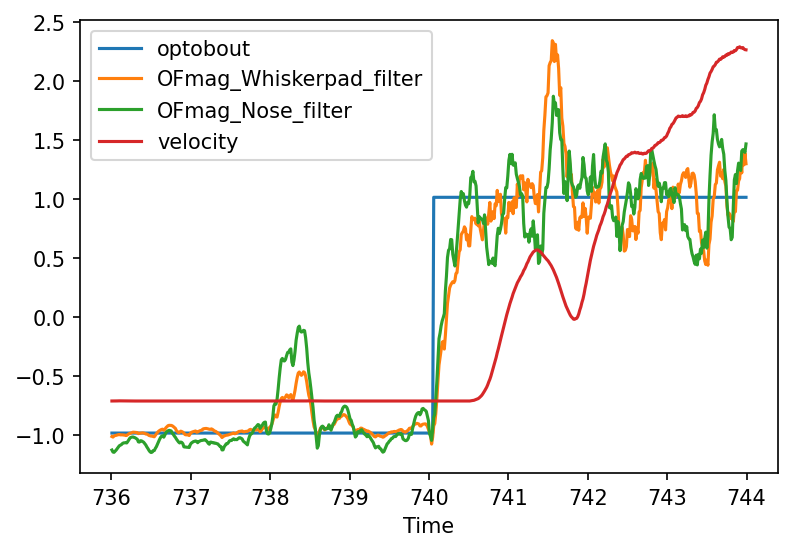

In [26]:
from scipy.signal import savgol_filter
pd.options.plotting.backend = "matplotlib"
testdata['OFmag_Whiskerpad_onsets'] = (zscore(testdata['OFmag_Whiskerpad'].rolling(5, center=True).mean().diff().fillna(0))>1).astype(int)
testdata['OFmag_Nose_onsets'] = (zscore(testdata['OFmag_Nose'].rolling(5, center=True).mean().diff().fillna(0))>1).astype(int)
testdata['OFmag_Nose_filter'] = savgol_filter(testdata['OFmag_Nose'], 25, 2)
testdata['OFmag_Whiskerpad_filter'] = savgol_filter(testdata['OFmag_Whiskerpad'], 25, 2)
testdata[['Time', 'optobout', 'OFmag_Whiskerpad_filter', 'OFmag_Nose_filter', 'velocity'
               ]].iloc[55_200:55_800].set_index('Time').fillna(0).apply(zscore).plot()
# plt.show()
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/facemotion_optoonset_example_212_Randomized_55200-55800.pdf')

## opto pre-post differences face motion (Fig. 2C)

               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.601671    5   two-sided  0.048152  [0.0, 0.58]  1.062128  2.147   

           power  
T-test  0.554168  
               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.780501    4   two-sided  0.049793  [0.0, 0.78]  1.243478  2.225   

           power  
T-test  0.558029  
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  4.077735    3   two-sided  0.026629  [0.05, 0.44]  2.038868  3.648   

           power  
T-test  0.769257  
               T  dof alternative     p-val        CI95%  cohen-d    BF10  \
T-test  4.952108    5   two-sided  0.004277  [0.3, 0.95]  2.02169  13.127   

           power  
T-test  0.973064  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.263112    3   two-sided  0.295792  [-0.28, 0.12]  0.631556  0.725   

           power  
T-test  0.147614  
               T  dof alterna

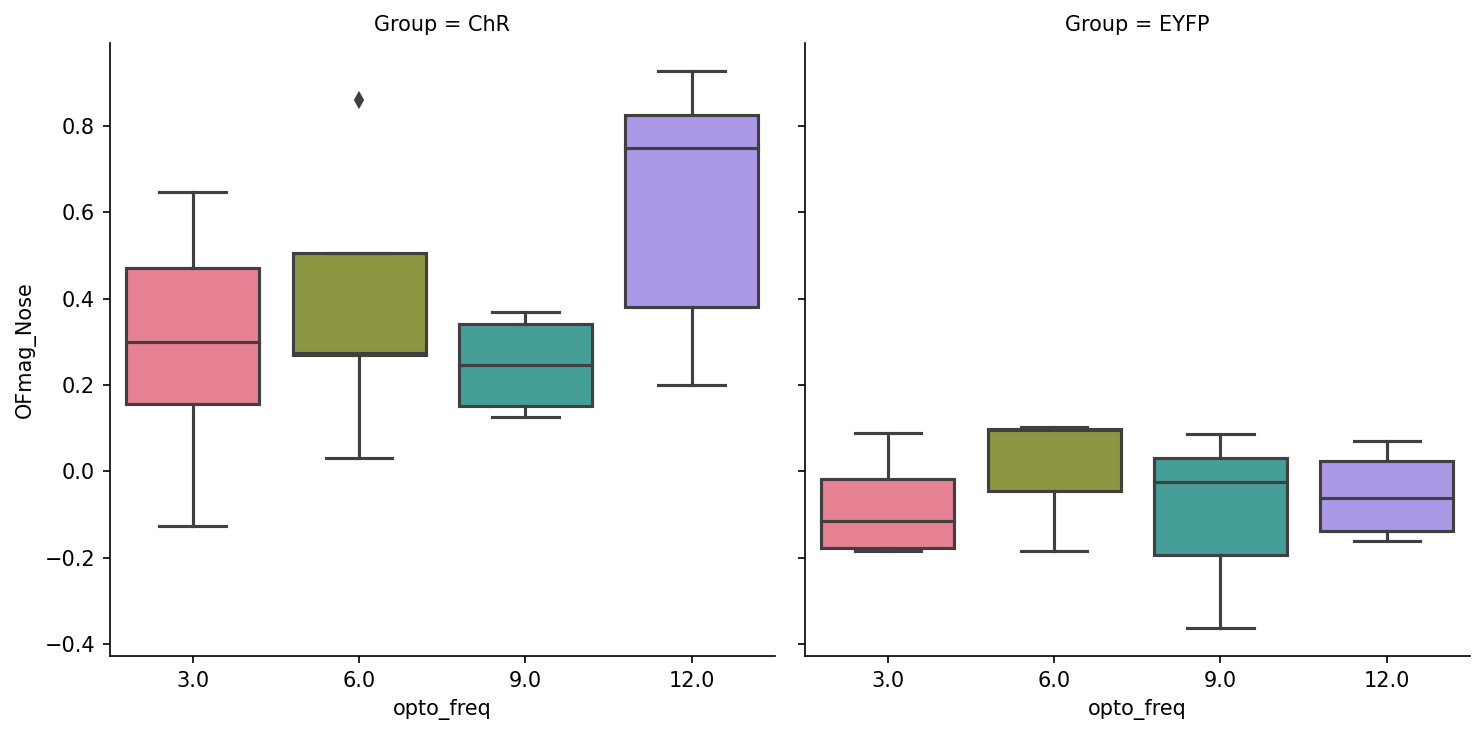

In [5]:
data['onset_opto_prepost'] = np.nan
data.loc[(data.onset_opto_time < 0)&(data.onset_opto_time > -60), 'onset_opto_prepost'] = 'pre'
data.loc[(data.onset_opto_time > 10)&(data.onset_opto_time < 60), 'onset_opto_prepost'] = 'post'
data['onset_opto_prepost'] = data['onset_opto_prepost'].astype('category').cat.reorder_categories(['pre', 'post'])
data.loc[data.opto_freq==10, 'opto_freq'] = 9
opto_epochs_diff = data.loc[data.onset_opto_prepost=='post'].groupby(['onset_opto_epoch', 'Experiment', 'Group', 'opto_freq', 'Mouse']).mean() - data.loc[data.onset_opto_prepost=='pre'].groupby(['onset_opto_epoch', 'Experiment', 'Group', 'opto_freq', 'Mouse']).mean()
opto_epochs_diff_bymouse = opto_epochs_diff.reset_index().groupby(['Group', 'opto_freq', 'Mouse']).mean()

opto_epochs_diff_bymouse = opto_epochs_diff_bymouse.reset_index()
sns.catplot(kind='box', data=opto_epochs_diff_bymouse, x='opto_freq', col='Group', y='OFmag_Nose', ci=68, palette='husl')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/opto_OFmagNose_stats_uncued.pdf')
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==3), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==6), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==9), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==12), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==3), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==6), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==9), 'OFmag_Nose'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==12), 'OFmag_Nose'], 0))

              T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.66836    5   two-sided  0.044436  [0.02, 1.12]  1.089353  2.276   

           power  
T-test  0.574657  
               T  dof alternative     p-val        CI95%   cohen-d  BF10  \
T-test  2.937037    4   two-sided  0.042514  [0.05, 1.8]  1.313483  2.49   

           power  
T-test  0.601973  
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.620426    3   two-sided  0.078973  [-0.11, 1.1]  1.310213  1.746   

          power  
T-test  0.43787  
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  3.478441    5   two-sided  0.017688  [0.28, 1.87]  1.420068  4.498   

           power  
T-test  0.792307  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.299536    3   two-sided  0.284607  [-0.64, 0.27]  0.649768  0.743   

           power  
T-test  0.153281  
               T  dof alternati

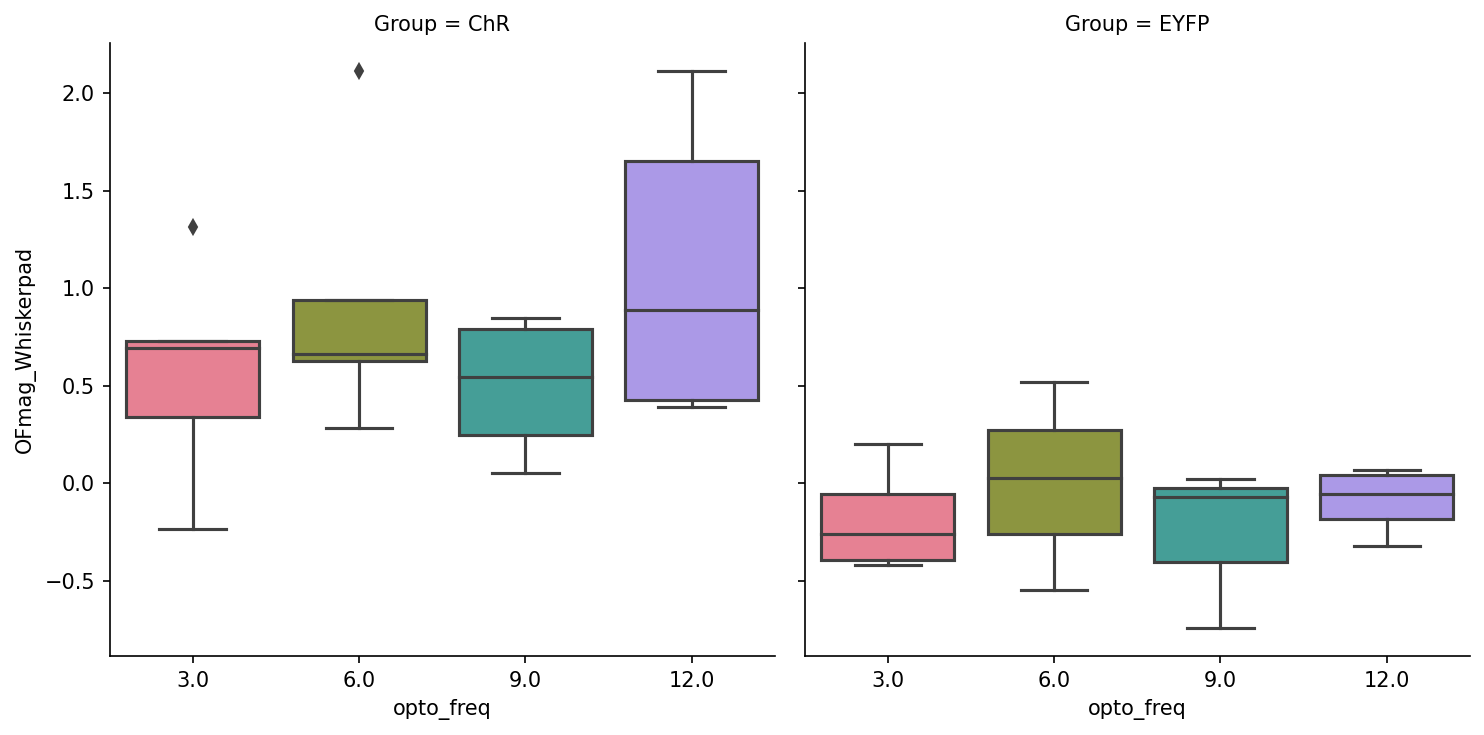

In [6]:
data['onset_opto_prepost'] = np.nan
data.loc[(data.onset_opto_time < 0)&(data.onset_opto_time > -60), 'onset_opto_prepost'] = 'pre'
data.loc[(data.onset_opto_time > 10)&(data.onset_opto_time < 60), 'onset_opto_prepost'] = 'post'
data['onset_opto_prepost'] = data['onset_opto_prepost'].astype('category').cat.reorder_categories(['pre', 'post'])
data.loc[data.opto_freq==10, 'opto_freq'] = 9
opto_epochs_diff = data.loc[data.onset_opto_prepost=='post'].groupby(['onset_opto_epoch', 'Experiment', 'Group', 'opto_freq', 'Mouse']).mean() - data.loc[data.onset_opto_prepost=='pre'].groupby(['onset_opto_epoch', 'Experiment', 'Group', 'opto_freq', 'Mouse']).mean()
opto_epochs_diff_bymouse = opto_epochs_diff.reset_index().groupby(['Group', 'opto_freq', 'Mouse']).mean()

opto_epochs_diff_bymouse = opto_epochs_diff_bymouse.reset_index()
sns.catplot(kind='box', data=opto_epochs_diff_bymouse, x='opto_freq', col='Group', y='OFmag_Whiskerpad', ci=68, palette='husl')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/opto_OFmagWhiskers_stats_uncued.pdf')
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==3), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==6), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==9), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='ChR')&(opto_epochs_diff_bymouse.opto_freq==12), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==3), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==6), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==9), 'OFmag_Whiskerpad'], 0))
print(pg.ttest(opto_epochs_diff_bymouse.loc[(opto_epochs_diff_bymouse.Group=='EYFP')&(opto_epochs_diff_bymouse.opto_freq==12), 'OFmag_Whiskerpad'], 0))

# Licodaine

In [7]:
# LOAD DATA
trial_type = 'lidocaine'
data = pd.read_feather('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/lidocaine.feather')
data

,sweep_index,position_raw,licking,pump,optotrigger,camtrigger_raw,sweep,camtrigger,optobout,opto_freq,...,onset_OFmag_Whiskerpad,onset_OFmag_Whiskerpad_time,onset_OFmag_Whiskerpad_epoch,onset_OFmag_Nose,onset_OFmag_Nose_time,onset_OFmag_Nose_epoch,opto_freq_sharp,stride_epoch,lfp,face_frame_diff
0,71.0,-0.006562,0.002500,0.000625,0.0,0.0,1.0,0.0,False,NaN,...,0,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN
1,209.0,-0.001875,0.001875,0.000625,0.0,0.0,1.0,0.0,False,NaN,...,0,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN
2,342.0,0.003438,0.002500,0.000625,0.0,0.0,1.0,0.0,False,NaN,...,0,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN
3,475.0,0.003750,0.002500,0.000625,0.0,0.0,1.0,0.0,False,NaN,...,0,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN
4,608.0,0.010000,0.002188,0.000625,0.0,0.0,1.0,0.0,False,NaN,...,0,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954480,NaN,3.120625,0.000937,0.000000,0.0,0.0,49.0,0.0,False,3.0,...,0,21.0,490.0,0,23.0,1067.0,0.0,NaN,NaN,NaN
1954481,NaN,3.132812,0.001250,0.000000,0.0,0.0,49.0,0.0,False,3.0,...,0,21.0,490.0,0,23.0,1067.0,0.0,NaN,NaN,NaN
1954482,NaN,3.133125,0.001250,0.000000,0.0,0.0,49.0,0.0,False,3.0,...,0,21.0,490.0,0,23.0,1067.0,0.0,NaN,NaN,NaN
1954483,NaN,3.143750,0.000937,0.000000,0.0,0.0,49.0,0.0,False,3.0,...,0,21.0,490.0,0,23.0,1067.0,0.0,NaN,NaN,NaN


In [8]:
data['onset_opto_prepost'] = np.nan
data.loc[(data.onset_opto_time < 0)&(data.onset_opto_time > -60), 'onset_opto_prepost'] = 'pre'
data.loc[(data.onset_opto_time > 10)&(data.onset_opto_time < 60), 'onset_opto_prepost'] = 'post'
data['onset_opto_prepost'] = data['onset_opto_prepost'].astype('category').cat.reorder_categories(['pre', 'post'])
data.loc[data.opto_freq==10, 'opto_freq'] = 9
opto_epochs_diff = (data.loc[data.onset_opto_prepost=='post'].groupby(['Group', 'onset_opto_epoch', 'Experiment', 'lidocaine', 'opto_freq', 'Mouse']).mean() - data.loc[data.onset_opto_prepost=='pre'].groupby(['onset_opto_epoch', 'Experiment', 'lidocaine', 'opto_freq', 'Mouse']).mean()).reset_index()
opto_epochs_diff = opto_epochs_diff.loc[(opto_epochs_diff.Group=='ChR')]
opto_epochs_diff_bymouse = opto_epochs_diff.groupby(['lidocaine', 'Mouse', 'opto_freq']).mean().reset_index()

opto_epochs_diff_bymouse = opto_epochs_diff_bymouse.reset_index()


## Figure 2H

    Contrast         A          B  Paired  Parametric         T  dof  \
0  lidocaine  baseline  lidocaine    True        True -1.095392  4.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.334873  0.615 -0.674211  
    Contrast         A          B  Paired  Parametric         T  dof  \
0  lidocaine  baseline  lidocaine    True        True  0.308173  4.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.773332  0.413  0.140698  
    Contrast         A          B  Paired  Parametric         T  dof  \
0  lidocaine  baseline  lidocaine    True        True -0.525794  4.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.626832  0.445 -0.189411  
    Contrast         A          B  Paired  Parametric         T  dof  \
0  lidocaine  baseline  lidocaine    True        True -0.370682  4.0   

  alternative    p-unc   BF10    hedges  
0   two-sided  0.72967  0.421 -0.181339  


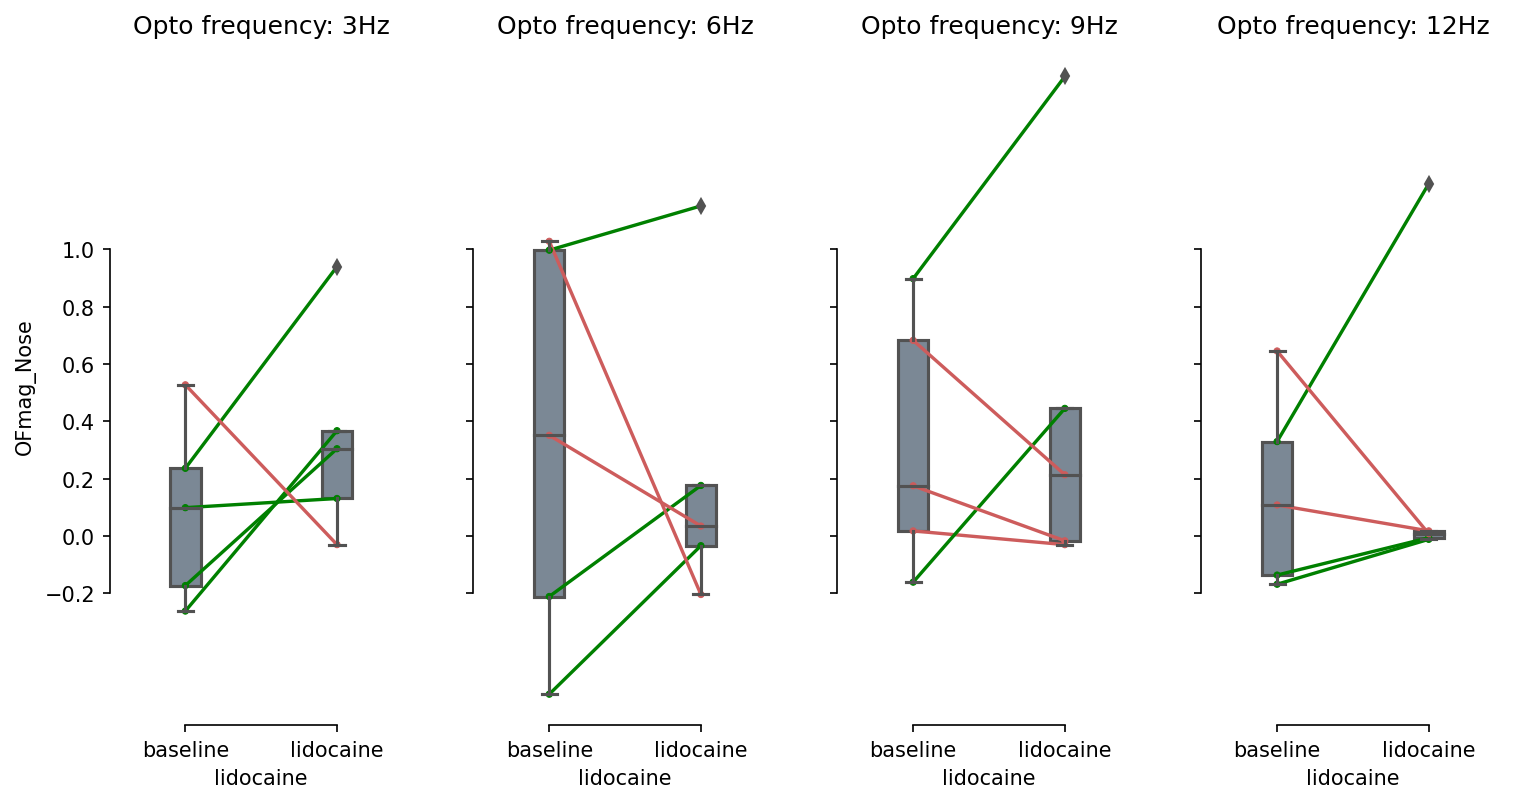

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(12,6), sharey=True)
for j, freq in enumerate([3, 6, 9, 12]):
    pg.plot_paired(dv='OFmag_Nose', within='lidocaine', data=opto_epochs_diff_bymouse.loc[opto_epochs_diff_bymouse.opto_freq==freq], subject='Mouse', ax=axs[j])
    print(pg.pairwise_tests(dv='OFmag_Nose', within='lidocaine', data=opto_epochs_diff_bymouse.loc[opto_epochs_diff_bymouse.opto_freq==freq], subject='Mouse', padjust='bonf'))
    axs[j].set_title('Opto frequency: {}Hz'.format(freq))                                                                                                           
plt.show()

# fig.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/opto_OFmagWhiskers_pairedstats_eachfreq_lidocaine.pdf')


## Figure 2G

    Contrast         A          B  Paired  Parametric         T  dof  \
0  lidocaine  baseline  lidocaine    True        True -0.992968  4.0   

  alternative     p-unc   BF10   hedges  
0   two-sided  0.376931  0.574 -0.72178  
    Contrast         A          B  Paired  Parametric        T  dof  \
0  lidocaine  baseline  lidocaine    True        True -0.02009  4.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.984934  0.397 -0.012583  
    Contrast         A          B  Paired  Parametric       T  dof  \
0  lidocaine  baseline  lidocaine    True        True -0.8991  4.0   

  alternative     p-unc  BF10    hedges  
0   two-sided  0.419431  0.54 -0.503118  
    Contrast         A          B  Paired  Parametric        T  dof  \
0  lidocaine  baseline  lidocaine    True        True -0.33243  4.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.756256  0.416 -0.243037  


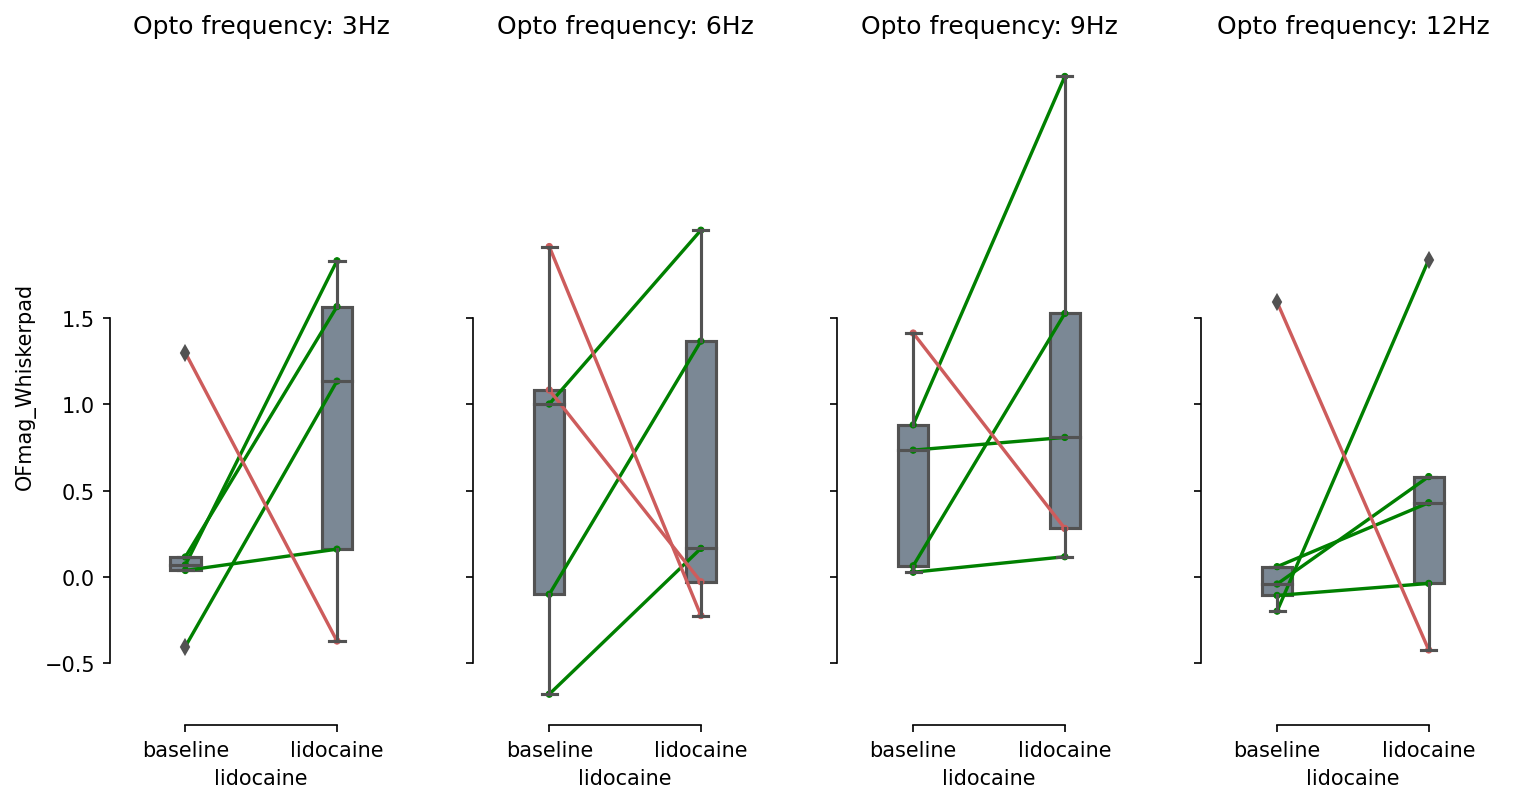

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12,6), sharey=True)
for j, freq in enumerate([3, 6, 9, 12]):
    pg.plot_paired(dv='OFmag_Whiskerpad', within='lidocaine', data=opto_epochs_diff_bymouse.loc[opto_epochs_diff_bymouse.opto_freq==freq], subject='Mouse', ax=axs[j])
    print(pg.pairwise_tests(dv='OFmag_Whiskerpad', within='lidocaine', data=opto_epochs_diff_bymouse.loc[opto_epochs_diff_bymouse.opto_freq==freq], subject='Mouse', padjust='bonf'))
    axs[j].set_title('Opto frequency: {}Hz'.format(freq))                                                                                                           
plt.show()

# fig.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/opto_OFmagWhiskers_pairedstats_eachfreq_lidocaine.pdf')


## opto/loco face motion onsets